In [1]:
import os
import cv2
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
from PIL import Image
from aot_tracker import _palette
import numpy as np
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc
def save_prediction(pred_mask,output_dir,file_name):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask.save(os.path.join(output_dir,file_name))
def colorize_mask(pred_mask):
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert(mode='RGB')
    return np.array(save_mask)
def draw_mask(img, mask, alpha=0.5, id_countour=False):
    img_mask = np.zeros_like(img)
    img_mask = img
    if id_countour:
        # very slow ~ 1s per image
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[obj_ids!=0]

        for id in obj_ids:
            # Overlay color on  binary mask
            if id <= 255:
                color = _palette[id*3:id*3+3]
            else:
                color = [0,0,0]
            foreground = img * (1-alpha) + np.ones_like(img) * alpha * np.array(color)
            binary_mask = (mask == id)

            # Compose image
            img_mask[binary_mask] = foreground[binary_mask]

            countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
            img_mask[countours, :] = 0
    else:
        binary_mask = (mask!=0)
        countours = binary_dilation(binary_mask,iterations=1) ^ binary_mask
        foreground = img*(1-alpha)+colorize_mask(mask)*alpha
        img_mask[binary_mask] = foreground[binary_mask]
        img_mask[countours,:] = 0
        
    return img_mask.astype(img.dtype)

/coc/flash9/abati7/Work/mimic/Segment-and-Track-Anything/src/groundingdino/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


In [2]:
from matplotlib import pyplot as plt

In [9]:
import matplotlib.image

a = np.ones((100,100))
a[30:40,30:40] += 2
a[40:50,40:50] += 5
matplotlib.image.imsave('name.png', a)


### Set parameters for input and output

In [2]:
video_name = 'cell'
io_args = {
    'input_video': f'./assets/{video_name}.mp4',
    'output_mask_dir': f'./assets/{video_name}_masks', # save pred masks
    'output_video': f'./assets/{video_name}_seg.mp4', # mask+frame vizualization, mp4 or avi, else the same as input video
    'output_gif': f'./assets/{video_name}_seg.gif', # mask visualization
}

### Tuning SAM on the First Frame for Good Initialization

In [ ]:
# choose good parameters in sam_args based on the first frame segmentation result
# other arguments can be modified in model_args.py
# note the object number limit is 255 by default, which requires < 10GB GPU memory with amp
sam_args['generator_args'] = {
        'points_per_side': 30,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    }
cap = cv2.VideoCapture(io_args['input_video'])
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()
with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        pred_mask = segtracker.seg(frame)
        torch.cuda.empty_cache()
        obj_ids = np.unique(pred_mask)
        obj_ids = obj_ids[obj_ids!=0]
        print("processed frame {}, obj_num {}".format(frame_idx,len(obj_ids)),end='\n')
        break
    cap.release()
    init_res = draw_mask(frame,pred_mask,id_countour=False)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(init_res)
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(colorize_mask(pred_mask))
    plt.show()

    del segtracker
    torch.cuda.empty_cache()
    gc.collect()

### Generate Results for the Whole Video

In [ ]:
# For every sam_gap frames, we use SAM to find new objects and add them for tracking
# larger sam_gap is faster but may not spot new objects in time
segtracker_args = {
    'sam_gap': 5, # the interval to run sam to segment new objects
    'min_area': 200, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
}

# source video to segment
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
# output masks
output_dir = io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
pred_list = []
masked_pred_list = []

torch.cuda.empty_cache()
gc.collect()
sam_gap = segtracker_args['sam_gap']
frame_idx = 0
segtracker = SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()

with torch.cuda.amp.autocast():
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        if frame_idx == 0:
            pred_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            segtracker.add_reference(frame, pred_mask)
        elif (frame_idx % sam_gap) == 0:
            seg_mask = segtracker.seg(frame)
            torch.cuda.empty_cache()
            gc.collect()
            track_mask = segtracker.track(frame)
            # find new objects, and update tracker with new objects
            new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)
            save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
            pred_mask = track_mask + new_obj_mask
            # segtracker.restart_tracker()
            segtracker.add_reference(frame, pred_mask)
        else:
            pred_mask = segtracker.track(frame,update_memory=True)
        torch.cuda.empty_cache()
        gc.collect()
        save_prediction(pred_mask,output_dir,str(frame_idx)+'.png')
        # masked_frame = draw_mask(frame,pred_mask)
        # masked_pred_list.append(masked_frame)
        # plt.imshow(masked_frame)
        # plt.show() 
        
        pred_list.append(pred_mask)
        
        
        print("processed frame {}, obj_num {}".format(frame_idx,segtracker.get_obj_num()),end='\r')
        frame_idx += 1
    cap.release()
    print('\nfinished')

### Save results for visualization

In [ ]:
# draw pred mask on frame and save as a video
cap = cv2.VideoCapture(io_args['input_video'])
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

if io_args['input_video'][-3:]=='mp4':
    fourcc =  cv2.VideoWriter_fourcc(*"mp4v")
elif io_args['input_video'][-3:] == 'avi':
    fourcc =  cv2.VideoWriter_fourcc(*"MJPG")
    # fourcc = cv2.VideoWriter_fourcc(*"XVID")
else:
    fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
out = cv2.VideoWriter(io_args['output_video'], fourcc, fps, (width, height))

frame_idx = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
    pred_mask = pred_list[frame_idx]
    masked_frame = draw_mask(frame,pred_mask)
    # masked_frame = masked_pred_list[frame_idx]
    masked_frame = cv2.cvtColor(masked_frame,cv2.COLOR_RGB2BGR)
    out.write(masked_frame)
    print('frame {} writed'.format(frame_idx),end='\r')
    frame_idx += 1
out.release()
cap.release()
print("\n{} saved".format(io_args['output_video']))
print('\nfinished')

In [ ]:
# save colorized masks as a gif
imageio.mimsave(io_args['output_gif'],pred_list,fps=fps)
print("{} saved".format(io_args['output_gif']))

In [6]:
# manually release memory (after cuda out of memory)
del segtracker
torch.cuda.empty_cache()
gc.collect()

301

## Processing Masks

In [58]:
base = '/nethome/abati7/flash/Work/mimic/Segment-and-Track-Anything/assets/IMG_3289_plain_masks_vith/'

In [59]:
with open(f"{base}{0}.npy", 'rb') as f:
    pred_mask = np.load(f)
height, width = pred_mask.shape
fps = 60

In [60]:
fourcc = cv2.VideoWriter_fourcc(*"mp4v")
out = cv2.VideoWriter("withBBOX3289_vith_detic.mp4", fourcc, fps, (width, height))
ref = cv2.VideoCapture("/nethome/abati7/flash/Work/mimic/Segment-and-Track-Anything/assets/IMG_3289.MOV")

In [61]:
import os
from tqdm import tqdm
for x in tqdm(range(len(os.listdir(base)))):
    with open(f"{base}{x}.npy", 'rb') as f:
        pred_mask = np.load(f)
    save_mask = Image.fromarray(pred_mask.astype(np.uint8))
    save_mask = save_mask.convert(mode='P')
    save_mask.putpalette(_palette)
    save_mask = save_mask.convert("RGB")
    
    image = cv2.cvtColor(np.array(save_mask),cv2.COLOR_RGB2BGR)
    for id in np.unique(pred_mask):
        if id == 0:
            continue
        currmask = np.argwhere(pred_mask == id)
        start_point = (np.min(currmask[:,1]), np.min(currmask[:,0]))
        end_point = (np.max(currmask[:,1]), np.max(currmask[:,0]))
        color = (255, 0, 0)
        thickness = 10
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        cv2.putText(image, f'ID: {id}', (np.min(currmask[:,1]), np.min(currmask[:,0]-20)), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 4)
    ok, frame = ref.read()
    image = (1-0.3) * image + 0.3 * frame
    image = image.astype(frame.dtype)
    out.write(image)
    # plt.imshow(image)
    # break
out.release()

100%|██████████| 302/302 [00:35<00:00,  8.62it/s]


In [6]:
from SegTracker import SegTracker
from model_args import aot_args,sam_args,segtracker_args
sys.path.append("/nethome/abati7/flash/Work/mimic/detectron2/")
sys.path.append("/nethome/abati7/flash/Work/mimic/Detic/")
sys.path.insert(0, '/nethome/abati7/flash/Work/mimic/Detic/third_party/CenterNet2/')

from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg
from centernet.config import add_centernet_config
from detic.config import add_detic_config
import mediapipe as mp


class Tracker:
    def __init__(self) -> None:
        sam_args['generator_args'] = {
            'points_per_side': 30,
            'pred_iou_thresh': 0.8,
            'stability_score_thresh': 0.9,
            'crop_n_layers': 1,
            'crop_n_points_downscale_factor': 2,
            'min_mask_region_area': 200,
        }
        segtracker_args = {
            'sam_gap': 100, # the interval to run sam to segment new objects
            'min_area': 200, # minimal mask area to add a new mask as a new object
            'max_obj_num': 255, # maximal object number to track in a video
            'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
        }
        self.segtracker = SegTracker(segtracker_args,sam_args,aot_args)
        self.segtracker.restart_tracker()

        self.frame_masks = None
        self.specificObjects = []
        self.fps = 30
        cfg = self.setup_detic_cfg()
        self.predictor = DefaultPredictor(cfg)

    def setup_detic_cfg(self):
        cfg = get_cfg()
        cfg.MODEL.DEVICE="cpu"
        add_centernet_config(cfg)
        add_detic_config(cfg)
        cfg.merge_from_file("/nethome/abati7/flash/Work/mimic/Detic/configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
        cfg.merge_from_list(["MODEL.WEIGHTS","/nethome/abati7/flash/Work/mimic/Detic/models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth"])
        # Set score_threshold for builtin models
        cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.55
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
        cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.55
        cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand' # load later
        cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True
        cfg.freeze()
        return cfg
    
    def process(self, video_path, anySpecificObject=[]):
        """
        - should take in video and run tracker
        - anySpecificObject = if we want to track specific objects in the video or not (use sam.segment_with_click for segtracker.add_reference_frame)
        - stores each frame in the self.frame_masks
        - make sure to show/tell the user what the "first frame" is because this is where the ids are initialized
        """
        cap = cv2.VideoCapture(video_path)
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = cap.get(cv2.CAP_PROP_FRAME_WIDTH )
        height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT )
        self.fps = fps
        self.frame_masks = np.empty((length, height, width))
        with torch.cuda.amp.autocast():
            for x in tqdm(range(length)):
                ret, frame = cap.read()
                if not ret:
                    break
                frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
                if frame_idx == 0:
                    if anySpecificObject:
                        self.specificObjects = anySpecificObject
                        predictions = self.predictor(frame) #TODO: define the detic predictor
                        boxes = predictions['instances'].pred_boxes.tensor.type(torch.int).tolist()
                        for rect in boxes:
                            x,y,x1,y1 = rect 
                            pred_mask, _ = segtracker.seg_acc_bbox(frame, [[x, y], [x1, y1]])
                        if 0 in pred_mask:
                            pred_mask[pred_mask == 0] = 100 #set everything not set to an id
                    else:
                        pred_mask = segtracker.seg(frame)
                    torch.cuda.empty_cache()
                    gc.collect()
                    segtracker.add_reference(frame, pred_mask)
                elif (frame_idx % sam_gap) == 0:
                    seg_mask = segtracker.seg(frame)
                    torch.cuda.empty_cache()
                    gc.collect()
                    track_mask = segtracker.track(frame)
                    # find new objects, and update tracker with new objects
                    new_obj_mask = segtracker.find_new_objs(track_mask,seg_mask)
                    save_prediction(new_obj_mask,output_dir,str(frame_idx)+'_new.png')
                    pred_mask = track_mask + new_obj_mask
                    # segtracker.restart_tracker()
                    segtracker.add_reference(frame, pred_mask)
                else:
                    pred_mask = segtracker.track(frame,update_memory=True)
                torch.cuda.empty_cache()
                gc.collect()
                # masked_frame = draw_mask(frame,pred_mask)
                # masked_pred_list.append(masked_frame)
                # plt.imshow(masked_frame)
                # plt.show() 
                
                self.frame_masks[x] = pred_mask
                
                
                # print("processed frame {} / {}, obj_num {}".format(frame_idx,length, segtracker.get_obj_num()),end='\r')
                frame_idx += 1
            cap.release()
            print('\nfinished')
            
    def getRectangleGivenID(self, mask, id):
        """
        - get rectangle coords given mask (h x w) and id
        """
        currmask = np.argwhere(mask == id)
        start_point = (np.min(currmask[:,1]), np.min(currmask[:,0]))
        end_point = (np.max(currmask[:,1]), np.max(currmask[:,0]))
        return start_point, end_point
        
    
    def getRectangles(self, mask):
        """
        - get rectangle coords for every object given mask
        """
        rects = []
        for id in np.unique(mask):
            rects.append(self.getRectangleGivenID(mask, id))
        return rects
    
    def getMaskImg(self, mask):
        """
        - 1 frame of video processing 
        - make sure to draw rectangles on screen based on self.specificObjects
        """
        save_mask = Image.fromarray(mask.astype(np.uint8))
        save_mask = save_mask.convert(mode='P')
        save_mask.putpalette(_palette)
        save_mask = save_mask.convert("RGB")
        
        image = cv2.cvtColor(np.array(save_mask),cv2.COLOR_RGB2BGR)
        for start, end in self.getRectangles(mask):
            color = (255, 0, 0)
            thickness = 10
            image = cv2.rectangle(image, start, end, color, thickness) 
            cv2.putText(image, f'ID: {id}', (start[0], start[1]-20), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 4)
        return image


    def curateVideo(self, output_path):
        """
        - get video of masks processed with rectangles drawn based on self.specificObjects
        """
        height, width = self.frame_masks[0].shape
        fps = self.fps
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        for x in tqdm(range(len(self.frame_masks))):
            image = self.getMaskImg(self.frame_masks[x])
            out.write(image)
        out.release()

    def get_binary_masks(id_mask):
        """
        get separate binary masks per id in the given mask
        """
        binary_masks = []
        for id in np.unique(id_mask):
            binary_masks.append(((id_mask == id)*id, id))

    def get_frame_point(self, frame, important_hand):
        # Initialize MediaPipe Hands
        mp_hands = mp.solutions.hands
        hands = mp_hands.Hands(static_image_mode=False,
                            max_num_hands=2,
                            min_detection_confidence=0.5,
                            min_tracking_confidence=0.5)
        # mp_drawing = mp.solutions.drawing_utils

        centers = [[], []]
        wrists = [[], []]
        finger_pts = [[], []]

        results = hands.process(frame)


        if results.multi_hand_world_landmarks:
            for hand_landmarks, hand_handedness in zip(results.multi_hand_landmarks, results.multi_handedness):
                # Get a constant index for the detected hand (0 or 1). If only 1 hand is detected, default to index = 0.
                hand_idx = hand_handedness.classification[0].index
                hand_label = hand_handedness.classification[0].label

                if important_hand == "R" and hand_label != "right":
                    continue
                elif important_hand == "L" and hand_label != 'left':
                    continue
                
                palm_points = np.asarray([
                        [hand_landmarks.landmark[4].x, hand_landmarks.landmark[4].y, hand_landmarks.landmark[4].z],
                        [hand_landmarks.landmark[8].x, hand_landmarks.landmark[8].y, hand_landmarks.landmark[8].z]])

                # both contact points
                finger_tips = np.copy(palm_points)
                finger_tips[:, 0] *= frame.shape[1]
                finger_tips[:, 1] *= frame.shape[0]
                # finger_pts[hand_idx].append(finger_tips)

                # Get hand center
                palm_points_mean = np.mean(palm_points, axis=0)
                center_x = int(palm_points_mean[0] * frame.shape[1])
                center_y = int(palm_points_mean[1] * frame.shape[0])
                # centers[hand_idx].append((center_x, center_y))
            
                wrist_center_x = int(hand_landmarks.landmark[0].x * frame.shape[1])
                wrist_center_y = int(hand_landmarks.landmark[0].y * frame.shape[0])
                # wrists[hand_idx].append((wrist_center_x, wrist_center_y))

                return finger_tips, (wrist_center_x, wrist_center_y)

    def get_contour_points(self, mask):
        mask_np = mask.astype(np.uint8)
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        points = np.vstack(contours).squeeze()
        return points

    def find_closest_mask(self, masks, point1, point2):
        min_distance = float('inf')
        min_idx = -1
        closest_mask = None
        
        for i, mask in enumerate(masks):
            contour_points = self.get_contour_points(mask)
            distances_point1 = np.linalg.norm(contour_points - np.array(point1), axis=1)
            distances_point2 = np.linalg.norm(contour_points - np.array(point2), axis=1)
            closest_distances_point1 = np.sort(distances_point1)   
            closest_distances_point2 = np.sort(distances_point2)  
            total_distance = np.mean(closest_distances_point1) + np.mean(closest_distances_point2)
            
            if total_distance < min_distance:
                min_distance = total_distance
                min_idx = i
                closest_mask = mask
                
        return closest_mask, min_idx
        
    def filter_arms_mask_by_points(self, masks, wrist_point):
        idx = -1
        area = float('-inf')
        for i in range(masks[0].shape[0]):
            if masks[i, wrist_point[0], wrist_point[1]] and torch.sum(masks[i] > 0) > area:
                area = torch.sum(masks[i] > 0)
                idx = i

        if idx == -1:
            print("No mask that contains wrist point.")
            return masks

        mask = torch.ones(masks.shape[0], dtype=torch.bool)
        mask[idx] = False
        filtered_masks = masks[mask]

        return filtered_masks

    def getTouchedObjectID(self, frameNum, frame, label):
        """
        - locationOfTouch - x,y point?
        - given a frame number (this should correspond to some mask in self.frame_masks) and touch location (x,y)
        find which mask it corresponds to (this should be done using arsh's function of contours or whtvr)
        - get object id from the mask

        Returns:
            first ish frame (this can be modified to whatever frame we need), id of the object we're looking for
        """
        id_mask = self.frame_masks[frameNum,:,:]
        finger_tips, wrist_point = self.get_frame_point(frame, label)
        masks = self.get_binary_masks(id_mask)
        filtered_masks = self.filter_arms_mask_by_points(masks, wrist_point[::-1])
        
        # find closest mask
        thumb_pt = [int(finger_tips[0, 0]), int(finger_tips[0, 1])]
        index_pt = [int(finger_tips[1, 0]), int(finger_tips[1, 1])]

        closest_mask, closest_idx = self.find_closest_mask(filtered_masks, thumb_pt, index_pt)
        unique_numbers = np.unique(closest_mask)
        id = unique_numbers[unique_numbers != 0][0]

        #TODO: GetClosestID() -> id -  Arsh use your code to get the best mask, then that mask should have the id
        return self.frame_masks[10, :, :], id
        

In [3]:
import cv2
import numpy as np
from IPython.display import display, Image
from PIL import Image as PILImage
import io
import matplotlib.patches as patches

cap = cv2.VideoCapture("/nethome/abati7/flash/Work/mimic/IMG_3288.MOV")
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
ok, frame = cap.read()


## External Stuff

In [33]:
from ultralytics import YOLO

model = YOLO("yolov8x.pt")  # load a pretrained model (recommended for training)
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
results = model(frame)  # predict on an image


0: 384x640 1 person, 3 knifes, 1 oven, 300.4ms
Speed: 5.7ms preprocess, 300.4ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


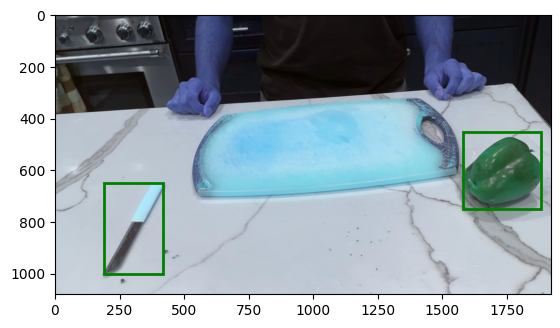

In [11]:
fig, ax = plt.subplots(1)
ax.imshow(frame)
rect1 = patches.Rectangle((190, 650), 230, 350, linewidth=2, edgecolor='g', facecolor='none')
rect2 = patches.Rectangle((1580, 450), 300, 300, linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(rect1)
ax.add_patch(rect2)

plt.show()

In [4]:
import sys
sys.path.append("/nethome/abati7/flash/Work/mimic/detectron2/")
sys.path.append("/nethome/abati7/flash/Work/mimic/Detic/")
sys.path.insert(0, '/nethome/abati7/flash/Work/mimic/Detic/third_party/CenterNet2/')
sys.path.insert(0, '/nethome/abati7/flash/Work/mimic/Detic/third_party/Deformable-DETR')

In [5]:
from detic.modeling.meta_arch.d2_deformable_detr import DeformableDetr

In [10]:
from detectron2.engine.defaults import DefaultPredictor
from detectron2.config import get_cfg
from centernet.config import add_centernet_config
from detic.config import add_detic_config

def setup_cfg():
    cfg = get_cfg()
    cfg.MODEL.DEVICE="cpu"
    add_centernet_config(cfg)
    add_detic_config(cfg)
    cfg.merge_from_file("/nethome/abati7/flash/Work/mimic/Detic/configs/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.yaml")
    cfg.merge_from_list(["MODEL.WEIGHTS","/nethome/abati7/flash/Work/mimic/Detic/models/Detic_LCOCOI21k_CLIP_SwinB_896b32_4x_ft4x_max-size.pth"])
    # Set score_threshold for builtin models
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.55
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.55
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.55
    cfg.MODEL.ROI_BOX_HEAD.ZEROSHOT_WEIGHT_PATH = 'rand' # load later
    cfg.MODEL.ROI_HEADS.ONE_CLASS_PER_PROPOSAL = True
    cfg.freeze()
    return cfg
cfg = setup_cfg()
predictor = DefaultPredictor(cfg)

In [11]:
frame = cv2.imread("/nethome/abati7/flash/Work/mimic/arsh.JPG")

In [12]:
predictions = predictor(frame)
boxes = predictions['instances'].pred_boxes.tensor.type(torch.int).tolist()

In [8]:
from transformers import AutoImageProcessor, DeformableDetrForObjectDetection
import torch
from PIL import Image
import requests

# url = "http://images.cocodataset.org/val2017/000000039769.jpg"

processor = AutoImageProcessor.from_pretrained("facebook/deformable-detr-detic")
model = DeformableDetrForObjectDetection.from_pretrained("facebook/deformable-detr-detic")
image = frame

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)
target_sizes = torch.tensor([image.shape[:2]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.6)[0]
boxes = []
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    boxes.append([int(i) for i in box.tolist()])

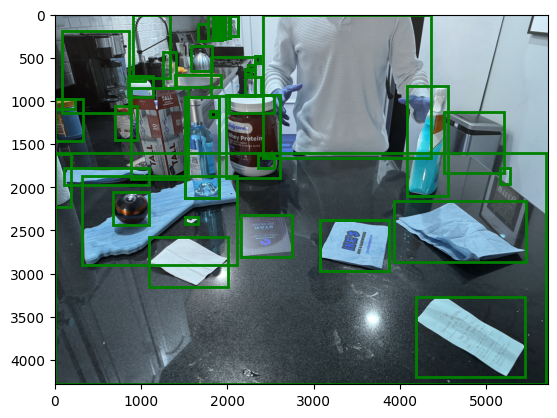

: 

In [13]:
fig, ax = plt.subplots(1)
ax.imshow(frame)
for rect in boxes:
    x,y,x1,y1 = rect
    rect1 = patches.Rectangle((x, y), x1-x, y1-y, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(rect1)

plt.show()
